In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install torchsde
!pip install torch==2.0.1+cu118 --index-url https://download.pytorch.org/whl/cu118


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://download.pytorch.org/whl/cu118

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
import importlib 
import models.mlp
import pdb
from tqdm import tqdm
from models.mlp import MyMLP, SpectralNormMLP

import torch
import torchsde

from functorch import vmap

#from torchdiffeq import odeint

In [3]:
from typing import Optional, Dict
from fab.types_ import LogProbFunc

import torch
import torch.nn as nn
import torch.nn.functional as f
from fab.target_distributions.base import TargetDistribution
from fab.utils.numerical import MC_estimate_true_expectation, quadratic_function, \
    importance_weighted_expectation, effective_sample_size_over_p, setup_quadratic_function


class ImageGMM(nn.Module, TargetDistribution):
    def __init__(self, means, log_var_scaling=0.1, seed=0,
                 n_test_set_samples=1000, use_gpu=True,
                 true_expectation_estimation_n_samples=int(1e7)):
        super().__init__()
        self.seed = seed
        self.n_mixes = len(means)
        self.n_test_set_samples = n_test_set_samples

        means = means.flatten(1, 2)
        self.dim = means.shape[1]
         
        #import pdb; pdb.set_trace()
        log_var = torch.ones((self.n_mixes, self.dim)) * log_var_scaling

        self.register_buffer("cat_probs", torch.ones(self.n_mixes))
        self.register_buffer("locs", means)
        self.register_buffer("scale_trils", torch.diag_embed(log_var))
        self.expectation_function = quadratic_function
    
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

        self.original_scale_trils = self.scale_trils.clone()

    def to(self, device):
        if device == "cpu":
            self.cpu()
        else:
            if torch.cuda.is_available():
                self.cuda()

    @property
    def distribution(self):
        mix = torch.distributions.Categorical(self.cat_probs)
        com = torch.distributions.MultivariateNormal(self.locs,
                                                     scale_tril=self.scale_trils,
                                                     validate_args=False)
        return torch.distributions.MixtureSameFamily(mixture_distribution=mix,
                                                     component_distribution=com,
                                                     validate_args=False)
    
    def convolve(self, var_t):
        """Convolve the current distribution with a Gaussian with covariance sigma_t."""
        var_t = var_t.to(self.device)
        var_trils = torch.ones((self.n_mixes, self.dim)).to(self.device) * var_t
        self.scale_trils = (self.scale_trils ** 2 + torch.diag_embed(var_trils)) ** 0.5

    def reset(self):
        self.scale_trils = self.original_scale_trils.clone()

    @property
    def test_set(self) -> torch.Tensor:
        return self.sample((self.n_test_set_samples, ))

    def log_prob(self, x: torch.Tensor):
        log_prob = self.distribution.log_prob(x)
        # Very low probability samples can cause issues (we turn off validate_args of the
        # distribution object which typically raises an expection related to this.
        # We manually decrease the distributions log prob to prevent them having an effect on
        # the loss/buffer.
        # mask = torch.zeros_like(log_prob)
        # mask[log_prob < -1e4] = - torch.tensor(float("inf"))
        # log_prob = log_prob + mask
        return log_prob

    def sample(self, shape=(1,)):
        return self.distribution.sample(shape)

    def performance_metrics(self, samples: torch.Tensor, log_w: torch.Tensor,
                            log_q_fn: Optional[LogProbFunc] = None,
                            batch_size: Optional[int] = None) -> Dict:
        bias_normed = self.evaluate_expectation(samples, log_w)
        bias_no_correction = self.evaluate_expectation(samples, torch.ones_like(log_w))
        if log_q_fn:
            log_q_test = log_q_fn(self.test_set)
            log_p_test = self.log_prob(self.test_set)
            test_mean_log_prob = torch.mean(log_q_test)
            kl_forward = torch.mean(log_p_test - log_q_test)
            ess_over_p = effective_sample_size_over_p(log_p_test - log_q_test)
            summary_dict = {
                "test_set_mean_log_prob": test_mean_log_prob.cpu().item(),
                "bias_normed": torch.abs(bias_normed).cpu().item(),
                "bias_no_correction": torch.abs(bias_no_correction).cpu().item(),
                "ess_over_p": ess_over_p.detach().cpu().item(),
                "kl_forward": kl_forward.detach().cpu().item()
                            }
        else:
            summary_dict = {"bias_normed": bias_normed.cpu().item(),
                            "bias_no_correction": torch.abs(bias_no_correction).cpu().item()}
        return summary_dict

class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score_net):
        super().__init__()
        self.score_model = score_net
    
    def f(self, t, x):
        # pdb.set_trace()
        t = t.repeat(len(x)).to(x.device)
        score = self.score_model(x, 1-t)
        return self.g(t, x).pow(2) * score 
    
    def g(self, t, x):
        return torch.full_like(x, beta ** 0.5) #+ 0.1

def save_gmm_as_numpy(target: ImageGMM):
    """Save params of GMM problem."""
    import pickle
    x_shift, A, b = setup_quadratic_function(torch.ones(target.dim), seed=0)
    params = {"mean": target.locs.numpy(),
              "scale_tril": target.scale_trils.numpy(),
              "true_expectation": target.true_expectation.numpy(),
              "expectation_x_shift": x_shift.numpy(),
              "expectation_A": A.numpy(),
              "expectation_b": b.numpy()
              }
    with open("gmm_problem.pkl", "wb") as f:
        pickle.dump(params, f)
        
def estimate_grad_Rt(x, t, beta=1.0, num_mc_samples=100):
    def grad_fxn(_x, _t):
        repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        h_t = beta * repeated_t
        
        # samples = repeated_x + torch.normal(torch.zeros_like(repeated_x), h_t.unsqueeze(1) ** 0.5)
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * h_t.unsqueeze(1) ** 0.5
        log_rewards = target_distrib.log_prob(samples)#unnormalize(samples, global_mins, global_maxs))
        
        #import pdb; pdb.set_trace()
        mean_reward = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
        return mean_reward
        return torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    
    t = t * torch.ones(x.shape[0]).to(device)
    est_scores = torch.vmap(torch.func.grad(grad_fxn), randomness='different')(x, t)
    return est_scores

def estimate_grad_Rt_vp(x, t, num_mc_samples=100):
    def grad_fxn(_x, _t):
        h_t = _t.repeat_interleave(num_mc_samples).unsqueeze(1)# / global_maxs
        repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        
        samples = (repeated_x / (1 - repeated_t).sqrt().unsqueeze(1)) + (torch.normal(torch.zeros_like(repeated_x), h_t.sqrt()).to(device))
        log_rewards = target_distrib.log_prob(samples)#unnormalize(samples, global_mins, global_maxs))
        
        return torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    
    t = t * torch.ones(x.shape[0]).to(device)
    est_scores = torch.vmap(torch.func.grad(grad_fxn), randomness='different')(x, t)
    return est_scores

def true_Rt(x,  h_t):
    target_distrib.convolve(h_t[0])# * (50 ** 2))
    energy = target_distrib.log_prob(x)#unnormalize(x, global_mins, global_maxs))
    target_distrib.reset()
    return energy

def true_Rt_vp(x, h_t):
    target_distrib.convolve(h_t)
    energy = target_distrib.log_prob(x / (1 - h_t).sqrt())#unnormalize(x / (1 - t).sqrt(), global_mins, global_maxs))
    target_distrib.reset()
    return energy

def true_grad_Rt(x, h_t):
    with torch.enable_grad():
        x.requires_grad_()
        samples_energy = true_Rt(x, h_t)
        true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[0].detach()
    return true_scores.detach()

def true_grad_Rt_vp(x, h_t, global_mins=-50, global_maxs=50):
    samples_energy = true_Rt_vp(x, h_t)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[0].detach()
    return true_scores
        
def reward_matching_loss(target, vectorfield, constant_noise_scale, x, t):     
    t = t.unsqueeze(1)
    h_t = constant_noise_scale * t
    
    x.requires_grad = True

    # noisy sample: x(t)
    noisy_x = torch.normal(x, h_t ** 0.5)
    pred_scores = vectorfield(noisy_x, t.squeeze())

    estimated_scores = estimate_grad_Rt(noisy_x, t.squeeze(1), beta, 100)
    return ((estimated_scores - pred_scores)**2).mean()

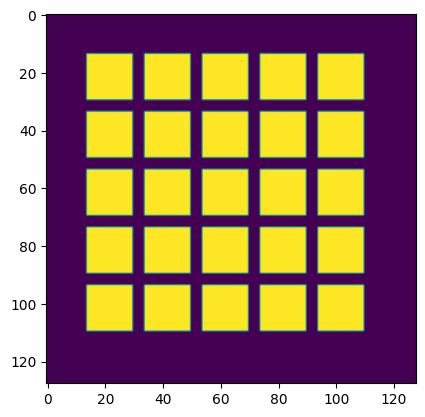

In [26]:
plt.imshow(img_vals.sum(dim=0).cpu())

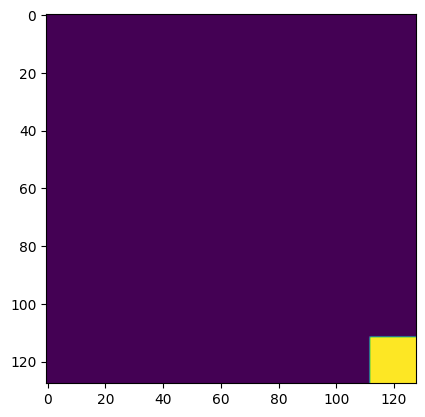

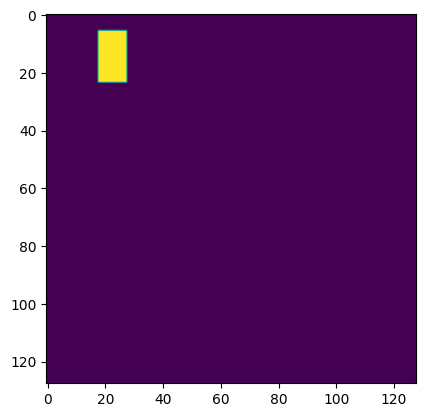

In [4]:
img_vals = torch.zeros((128, 128), dtype=torch.float, device='cuda')
img_vals[6:24,18:28] = 1.0

all_img_vals = [img_vals]

img_vals = torch.zeros((128, 128), dtype=torch.float, device='cuda')
img_vals[-16:, -16:] = 1.0
all_img_vals.append(img_vals)

img_vals = torch.stack(all_img_vals)
plt.imshow(img_vals[1].cpu())
plt.show()
plt.imshow(img_vals[0].cpu())

In [29]:
num_mc_samples = 10

def est_ve_score_wrapper(x, t):
    with torch.enable_grad():
        return estimate_grad_Rt(x, t, beta=beta, num_mc_samples=num_mc_samples)

ve_sde_est_score = VEReverseSDE(est_ve_score_wrapper)

num_samples = 2
target_distrib.convolve(torch.tensor(30.0, device=torch.device('cuda')))
x1_samples = target_distrib.sample((num_samples,))
target_distrib.reset()

In [27]:
t = torch.linspace(0.0, 1.0, 100)
with torch.no_grad():
    samples = torchsde.sdeint(ve_sde_est_score, x1_samples, t, method='euler')

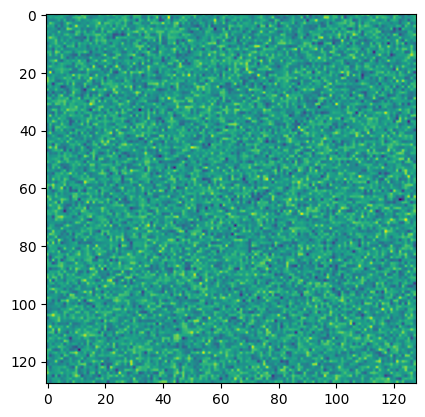

In [19]:
plt.imshow(x1_samples[0].reshape(128,128).detach().cpu())

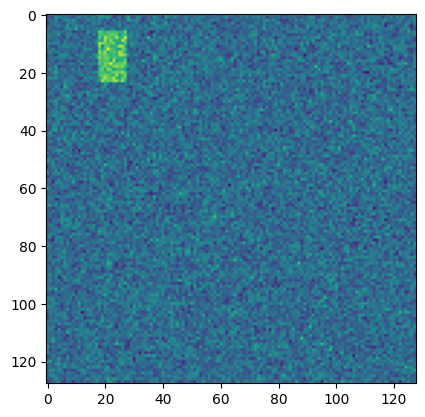

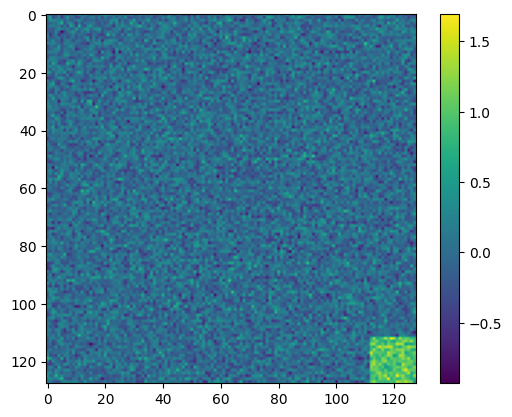

In [30]:
plt.imshow(samples[-1,1].reshape(128,128).cpu())
plt.show()
plt.imshow(samples[-1,0].reshape(128,128).cpu())
plt.colorbar()

In [5]:
target_distrib = ImageGMM(img_vals, log_var_scaling=1e-1)

num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
beta = 30.0
vectorfield = MyMLP(out_dim=128**2).to(device)

opt_vectorfield = Adam(vectorfield.parameters(), lr=1e-3)

In [5]:
train_dataset = TensorDataset(img_vals.clone().flatten(1,2))
trainloader = DataLoader(train_dataset, batch_size = 1, shuffle=True) 

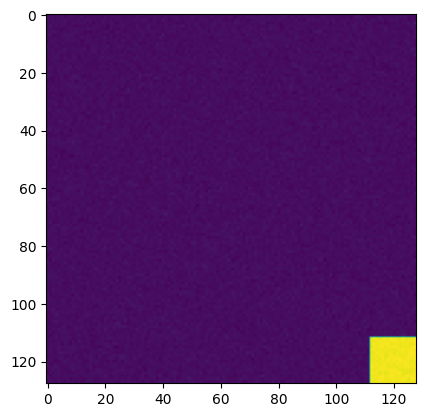

In [32]:
plt.imshow(target_distrib.sample().cpu().reshape(128,128))

In [13]:

beta = 30.0

losses = []
for epoch in range(500):
    for samples in trainloader:
        samples = samples[0].to(device)
        opt_vectorfield.zero_grad()
        t = torch.rand(len(samples), device=device)

        #low_time_t = (-0.1 * torch.rand(len(samples), device=device)) + 0.1
        #high_time_t = (-0.9 * torch.rand(len(samples), device=device)) + 1.0

        #mask = torch.rand(len(samples), device=device) < 0.8

        #t = (low_time_t * mask) + (high_time_t * ~mask)

        loss = reward_matching_loss(target_distrib, vectorfield, beta, samples, t) / 10000
        loss.backward()
        opt_vectorfield.step()
        losses.append(loss.item())
    if epoch % 25 == 0:
        print("Epoch %d | Loss %f" % (epoch, loss.item()))


Epoch 0 | Loss 12.922230
Epoch 25 | Loss 44.306324
Epoch 50 | Loss 15.095537
Epoch 75 | Loss 41.184792
Epoch 100 | Loss 28.579802
Epoch 125 | Loss 18.840078
Epoch 150 | Loss 21.010254
Epoch 175 | Loss 50.351830
Epoch 200 | Loss 6.208575
Epoch 225 | Loss 0.634224
Epoch 250 | Loss 28.748125
Epoch 275 | Loss 11.133512
Epoch 300 | Loss 23.996540
Epoch 325 | Loss 9.639632
Epoch 350 | Loss 3.908873
Epoch 375 | Loss 51.190342
Epoch 400 | Loss 0.643038
Epoch 425 | Loss 25.366903
Epoch 450 | Loss 57.375385
Epoch 475 | Loss 56.415623


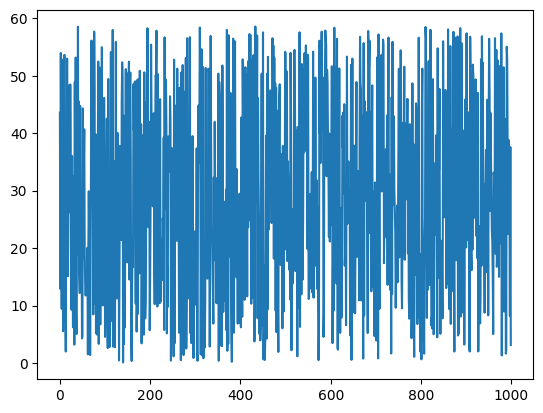

In [14]:
plt.plot(np.array(losses))

In [40]:
samples.shape

torch.Size([1, 16384])

In [46]:
samples = dataset[:1]

t = torch.full((len(samples),), 0.99)
h_t = t.clone() * beta

samples.requires_grad = True

# noisy sample: x(t)
noisy_x = torch.normal(samples, h_t.unsqueeze(1) ** 0.5)

all_vals = []
for mc_sample_size in tqdm(range(1, 101, 25)):
    many_ests = torch.stack([
        estimate_grad_Rt(noisy_x, t, mc_sample_size) 
        for _ in range(5)
    ]).squeeze()
    
    all_vals.append(many_ests.mean(dim=0).abs().mean().item())

100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


In [9]:
samples = torch.randn((1, 128 * 128), device='cuda')
t_vals = torch.linspace(0.0, 1.0, 100)

beta = 30.0
true_norms = []
est_norms = []

true_grad_fxn = torch.func.grad(true_Rt)
for t_val in tqdm(t_vals):
    t = torch.full((len(samples),), t_val, device='cuda')
    h_t = beta * t
    
    est_score = estimate_grad_Rt(samples, t, 100) 
    true_score = torch.vmap(true_grad_fxn)(samples, h_t.unsqueeze(0))
    
    true_norms.append(true_score.squeeze().pow(2).sum().sqrt())
    est_norms.append(est_score.squeeze().pow(2).sum().sqrt())

100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


In [10]:
true_norms = torch.stack(true_norms)
est_norms = torch.stack(est_norms)

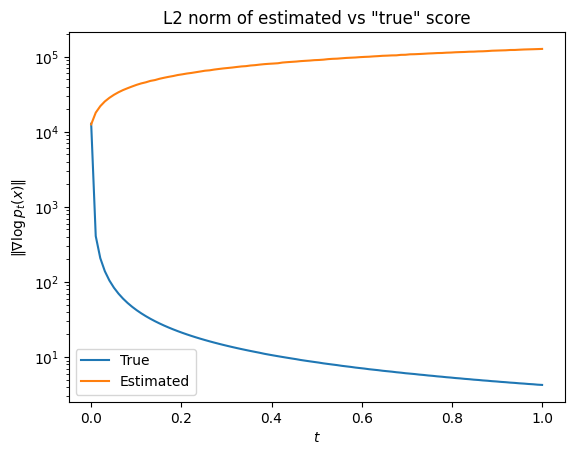

In [11]:
plt.plot(t_vals, true_norms.cpu(), label='True')
plt.plot(t_vals, est_norms.cpu(), label='Estimated')
plt.yscale('log')

plt.xlabel(r'$t$')
plt.ylabel(r'$\|\nabla \log p_t(x)\|$')

plt.title('L2 norm of estimated vs "true" score')
plt.legend()

In [47]:
all_vals = np.array(all_vals)

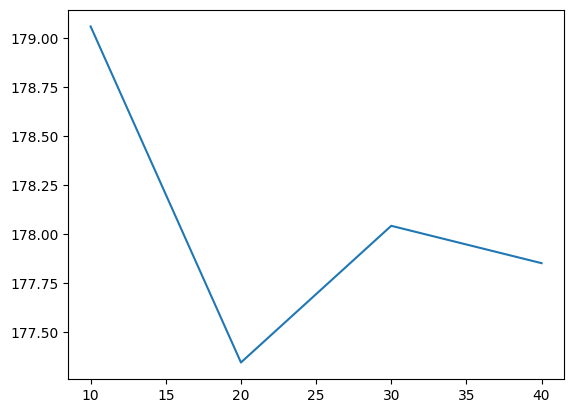

In [48]:
plt.plot((1 + np.arange(len(all_vals))) * 10, all_vals)

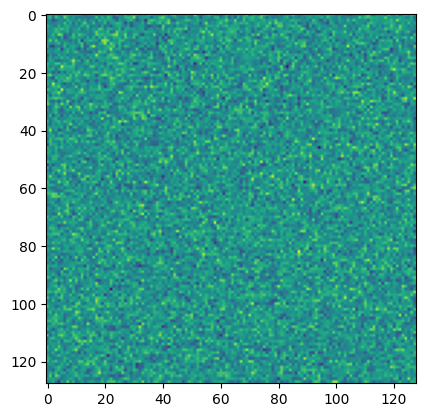

In [49]:
plt.imshow(noisy_x[0].reshape(128,128).detach())

In [30]:
target_distrib.convolve(h_t)
energy = target_distrib.log_prob(noisy_x / (1 - h_t).sqrt())
target_distrib.reset()

In [33]:
h_t

tensor([1.])

In [41]:
true_scores = torch.autograd.grad(energy.sum(), noisy_x, retain_graph=True)[0].detach()

In [45]:
torch.vmap(torch.func.grad(true_Rt_vp))(noisy_x, h_t)

tensor([[  0.9036, -10.5139,   8.3672,  ...,  20.7406, -20.9135, -37.7883]],
       grad_fn=<DivBackward0>)

In [43]:
estimate_grad_Rt_vp(noisy_x, t, 100) 

tensor([[ -213.9457, -1160.5935,  1038.2006,  ...,  2495.7483, -1996.7660,
         -4171.5278]], grad_fn=<SqueezeBackward2>)

In [46]:
true_scores

tensor([[  0.9036, -10.5139,   8.3672,  ...,  20.7406, -20.9135, -37.7883]])

In [42]:
def vp_grad_fxn(_x, _t, num_mc_samples):
    h_t = _t.repeat_interleave(num_mc_samples).unsqueeze(1)# / global_maxs
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)

    samples = (_x ) + (torch.normal(torch.zeros_like(_x), h_t.sqrt()).to(device))
    samples = _x
    #/ (1 - repeated_t).sqrt().unsqueeze(1)
    log_rewards = target_distrib.log_prob(samples)#unnormalize(samples, global_mins, global_maxs))

    return torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)

def estimate_grad_Rt_vp(x, t, num_mc_samples=100):
    t = t * torch.ones(x.shape[0]).to(device)
    est_scores = torch.vmap(torch.func.grad(vp_grad_fxn), randomness='different')(x, t)
    return est_scores

In [86]:
torch.vmap(torch.func.grad(vp_grad_fxn), in_dims=(0, 0, None), randomness='different')(noisy_x, t, 1)

tensor([[   5.2178,  -60.7142,   48.3180,  ...,  119.7701, -120.7689,
         -218.2151]], grad_fn=<SqueezeBackward2>)

In [87]:
torch.vmap(torch.func.grad(target_distrib.log_prob))(noisy_x)

tensor([[   5.2178,  -60.7142,   48.3180,  ...,  119.7701, -120.7689,
         -218.2151]], grad_fn=<SqueezeBackward2>)

In [89]:
target_distrib.convolve(h_t)
target_distrib.log_prob(noisy_x / (1 - h_t).sqrt())

tensor([-148261.1719], grad_fn=<LogsumexpBackward0>)

In [90]:
target_distrib.reset()

In [56]:
def true_Rt(x,  h_t):
    target_distrib.convolve(h_t[0])# * (50 ** 2))
    energy = target_distrib.log_prob(x)#unnormalize(x, global_mins, global_maxs))
    target_distrib.reset()
    return energy

def grad_fxn_ve(_x, _t, num_mc_samples, beta):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t = beta * repeated_t

    # samples = repeated_x + torch.normal(torch.zeros_like(repeated_x), h_t.unsqueeze(1) ** 0.5)
    samples = repeated_x + (torch.randn(repeated_x.shape).to(device) * h_t.unsqueeze(1) ** 0.5)
    log_rewards = target_distrib.log_prob(samples)#unnormalize(samples, global_mins, global_maxs))

    #import pdb; pdb.set_trace()
    
    half_log_rewards = log_rewards[..., :int(num_mc_samples / 2)]
   # return (2 * torch.logsumexp(log_rewards, dim=-1)) - torch.logsumexp(half_log_rewards, dim=-1)
    #mean_reward = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    #return mean_reward
    return torch.logsumexp(log_rewards.squeeze(), dim=-1) - np.log(num_mc_samples)

def non_batched_grad_fxn_ve(_x, _t, num_mc_samples, beta):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t = beta * repeated_t

    # samples = repeated_x + torch.normal(torch.zeros_like(repeated_x), h_t.unsqueeze(1) ** 0.5)
    samples = repeated_x + (torch.randn(repeated_x.shape).to(device) * h_t ** 0.5)
    log_rewards = target_distrib.log_prob(samples)#unnormalize(samples, global_mins, global_maxs))

    #import pdb; pdb.set_trace()
    
    half_log_rewards = log_rewards[..., :int(num_mc_samples / 2)]
   # return (2 * torch.logsumexp(log_rewards, dim=-1)) - torch.logsumexp(half_log_rewards, dim=-1)
    #mean_reward = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    #return mean_reward
    return torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)

def estimate_grad_Rt(x, t, num_mc_samples=1000, beta=1.0):
    t = t * torch.ones(x.shape[0]).to(device)
    return torch.vmap(
        torch.func.grad(grad_fxn_ve), 
        in_dims=(0, 0, None, None), 
        randomness='different'
    )(x, t, num_mc_samples, beta)
    

In [59]:
true_Rt(noisy_x, t.unsqueeze(0) * 5)

tensor([-36270.5703], grad_fn=<LogsumexpBackward0>)

In [69]:
def v(num_mc_samples):
    with torch.no_grad():
        return grad_fxn_ve(noisy_x, t, num_mc_samples, 5.0)
    
est_rt = np.array([v(i).detach() for i in tqdm([1, 10, 100, 1000, 10000, 100000])])

100%|██████████| 6/6 [02:39<00:00, 26.66s/it]


In [71]:
est_rt

array([-8115911. , -7822642.5, -7892527.5, -7798544.5, -7771584.5,
       -7689904. ], dtype=float32)

In [51]:
torch.vmap(torch.func.grad(true_Rt))(noisy_x, t.unsqueeze(0) * 500)

tensor([[ 0.0036, -0.0038,  0.0039,  ...,  0.0048, -0.0049, -0.0033]],
       grad_fn=<SqueezeBackward2>)

In [16]:
torch.vmap(torch.func.grad(target_distrib.log_prob))(noisy_x)

tensor([[ 4333.5796, -2624.7122, -2200.6567,  ...,  1017.6087,   325.9730,
         -1591.8329]], grad_fn=<SqueezeBackward2>)

In [37]:
est = estimate_grad_Rt(noisy_x, t, beta=500.0)

> /tmp/ipykernel_7246/3526673246.py(23)grad_fxn_ve()
     21     #return mean_reward
     22     import pdb; pdb.set_trace()
---> 23     return torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
     24 
     25 def estimate_grad_Rt(x, t, num_mc_samples=1000, beta=1.0):



ipdb>  log_rewards.shape


torch.Size([1000])


ipdb>  torch.logsumexp(log_rewards, dim=-1).shape


torch.Size([])


ipdb>  torch.logsumexp(log_rewards, dim=-1)


GradTrackingTensor(lvl=2, value=
    BatchedTensor(lvl=1, bdim=0, value=
        tensor([-7.9291e+08], grad_fn=<LogsumexpBackward0>)
    )
)


ipdb>  q


In [18]:
est

tensor([[ 3237.5210, -1061.0039,  4767.4678,  ...,  3395.7563,  -783.6194,
           727.7708]], grad_fn=<SqueezeBackward2>)

In [144]:
(est-est.mean())/est.std()

tensor([[-0.1469,  0.7875,  2.6835,  ...,  0.4696,  1.8790, -0.0819]],
       grad_fn=<DivBackward0>)

In [146]:
(true-true.mean())/true.std()

tensor([[-0.4926,  0.9341,  1.4699,  ..., -0.5620,  1.3934, -0.4250]],
       grad_fn=<DivBackward0>)

In [147]:
(est - true).abs().mean()

tensor(194.1331, grad_fn=<MeanBackward0>)

In [148]:
est /194.1331

tensor([[-0.1856,  0.9880,  3.3694,  ...,  0.5887,  2.3589, -0.1039]],
       grad_fn=<DivBackward0>)

In [28]:
device = torch.device('cpu')

In [44]:
x1 = non_batched_grad_fxn_ve(noisy_x[0], t, 100, beta)
x2 = non_batched_grad_fxn_ve(noisy_x[0] + 1e-6, t, 100, beta)

In [45]:
print(x1)
print(x2)
print((x2-x1) / 1e-6)

tensor(-4.1308e+08, grad_fn=<SubBackward0>)
tensor(-4.1289e+08, grad_fn=<SubBackward0>)
tensor(1.8758e+11, grad_fn=<DivBackward0>)


In [ ]:
def v():
    import pdb; pdb.set_trace()
    y = img_vals.flatten(1,2)
    target_distrib.log_prob(y)
v()q

> /tmp/ipykernel_7246/2602496214.py(3)v()
      1 def v():
      2     import pdb; pdb.set_trace()
----> 3     y = img_vals.flatten(1,2)
      4     target_distrib.log_prob(y)
      5 v()



ipdb>  n


> /tmp/ipykernel_7246/2602496214.py(4)v()
      1 def v():
      2     import pdb; pdb.set_trace()
      3     y = img_vals.flatten(1,2)
----> 4     target_distrib.log_prob(y)
      5 v()



ipdb>  s


--Call--
> /tmp/ipykernel_7246/3363960605.py(67)log_prob()
     65         return self.sample((self.n_test_set_samples, ))
     66 
---> 67     def log_prob(self, x: torch.Tensor):
     68         log_prob = self.distribution.log_prob(x)
     69         # Very low probability samples can cause issues (we turn off validate_args of the



ipdb>  n


> /tmp/ipykernel_7246/3363960605.py(68)log_prob()
     66 
     67     def log_prob(self, x: torch.Tensor):
---> 68         log_prob = self.distribution.log_prob(x)
     69         # Very low probability samples can cause issues (we turn off validate_args of the
     70         # distribution object which typically raises an expection related to this.



ipdb>  s


--Call--
> /tmp/ipykernel_7246/3363960605.py(44)distribution()
     42                 self.cuda()
     43 
---> 44     @property
     45     def distribution(self):
     46         mix = torch.distributions.Categorical(self.cat_probs)



ipdb>  n


> /tmp/ipykernel_7246/3363960605.py(46)distribution()
     44     @property
     45     def distribution(self):
---> 46         mix = torch.distributions.Categorical(self.cat_probs)
     47         com = torch.distributions.MultivariateNormal(self.locs,
     48                                                      scale_tril=self.scale_trils,



ipdb>  


> /tmp/ipykernel_7246/3363960605.py(47)distribution()
     45     def distribution(self):
     46         mix = torch.distributions.Categorical(self.cat_probs)
---> 47         com = torch.distributions.MultivariateNormal(self.locs,
     48                                                      scale_tril=self.scale_trils,
     49                                                      validate_args=True)



ipdb>  self.locs


tensor([[0., 0., 0.,  ..., 0., 0., 0.]])


ipdb>  n


> /tmp/ipykernel_7246/3363960605.py(48)distribution()
     46         mix = torch.distributions.Categorical(self.cat_probs)
     47         com = torch.distributions.MultivariateNormal(self.locs,
---> 48                                                      scale_tril=self.scale_trils,
     49                                                      validate_args=True)
     50         return torch.distributions.MixtureSameFamily(mixture_distribution=mix,



ipdb>  


> /tmp/ipykernel_7246/3363960605.py(49)distribution()
     47         com = torch.distributions.MultivariateNormal(self.locs,
     48                                                      scale_tril=self.scale_trils,
---> 49                                                      validate_args=True)
     50         return torch.distributions.MixtureSameFamily(mixture_distribution=mix,
     51                                                      component_distribution=com,



ipdb>  


> /tmp/ipykernel_7246/3363960605.py(47)distribution()
     45     def distribution(self):
     46         mix = torch.distributions.Categorical(self.cat_probs)
---> 47         com = torch.distributions.MultivariateNormal(self.locs,
     48                                                      scale_tril=self.scale_trils,
     49                                                      validate_args=True)



ipdb>  


> /tmp/ipykernel_7246/3363960605.py(50)distribution()
     48                                                      scale_tril=self.scale_trils,
     49                                                      validate_args=True)
---> 50         return torch.distributions.MixtureSameFamily(mixture_distribution=mix,
     51                                                      component_distribution=com,
     52                                                      validate_args=True)



ipdb>  mix


Categorical(probs: tensor([1.]))


ipdb>  n


> /tmp/ipykernel_7246/3363960605.py(51)distribution()
     49                                                      validate_args=True)
     50         return torch.distributions.MixtureSameFamily(mixture_distribution=mix,
---> 51                                                      component_distribution=com,
     52                                                      validate_args=True)
     53 



ipdb>  


> /tmp/ipykernel_7246/3363960605.py(52)distribution()
     50         return torch.distributions.MixtureSameFamily(mixture_distribution=mix,
     51                                                      component_distribution=com,
---> 52                                                      validate_args=True)
     53 
     54     def convolve(self, var_t):



ipdb>  


> /tmp/ipykernel_7246/3363960605.py(50)distribution()
     48                                                      scale_tril=self.scale_trils,
     49                                                      validate_args=True)
---> 50         return torch.distributions.MixtureSameFamily(mixture_distribution=mix,
     51                                                      component_distribution=com,
     52                                                      validate_args=True)



ipdb>  


--Return--
MixtureSameFa...384, 16384])))
> /tmp/ipykernel_7246/3363960605.py(50)distribution()
     48                                                      scale_tril=self.scale_trils,
     49                                                      validate_args=True)
---> 50         return torch.distributions.MixtureSameFamily(mixture_distribution=mix,
     51                                                      component_distribution=com,
     52                                                      validate_args=True)



ipdb>  


--Call--
> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/mixture_same_family.py(159)log_prob()
    157         return torch.sum(cdf_x * mix_prob, dim=-1)
    158 
--> 159     def log_prob(self, x):
    160         if self._validate_args:
    161             self._validate_sample(x)



ipdb>  n


> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/mixture_same_family.py(160)log_prob()
    158 
    159     def log_prob(self, x):
--> 160         if self._validate_args:
    161             self._validate_sample(x)
    162         x = self._pad(x)



ipdb>  


> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/mixture_same_family.py(161)log_prob()
    159     def log_prob(self, x):
    160         if self._validate_args:
--> 161             self._validate_sample(x)
    162         x = self._pad(x)
    163         log_prob_x = self.component_distribution.log_prob(x)  # [S, B, k]



ipdb>  x.shape


torch.Size([1, 16384])


ipdb>  n


> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/mixture_same_family.py(162)log_prob()
    160         if self._validate_args:
    161             self._validate_sample(x)
--> 162         x = self._pad(x)
    163         log_prob_x = self.component_distribution.log_prob(x)  # [S, B, k]
    164         log_mix_prob = torch.log_softmax(



ipdb>  


> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/mixture_same_family.py(163)log_prob()
    161             self._validate_sample(x)
    162         x = self._pad(x)
--> 163         log_prob_x = self.component_distribution.log_prob(x)  # [S, B, k]
    164         log_mix_prob = torch.log_softmax(
    165             self.mixture_distribution.logits, dim=-1



ipdb>  s


--Call--
> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/mixture_same_family.py(128)component_distribution()
    126         return self._mixture_distribution
    127 
--> 128     @property
    129     def component_distribution(self):
    130         return self._component_distribution



ipdb>  n


> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/mixture_same_family.py(130)component_distribution()
    128     @property
    129     def component_distribution(self):
--> 130         return self._component_distribution
    131 
    132     @property



ipdb>  


--Return--
MultivariateN...6384, 16384]))
> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/mixture_same_family.py(130)component_distribution()
    128     @property
    129     def component_distribution(self):
--> 130         return self._component_distribution
    131 
    132     @property



ipdb>  


--Call--
> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/multivariate_normal.py(244)log_prob()
    242         return self.loc + _batch_mv(self._unbroadcasted_scale_tril, eps)
    243 
--> 244     def log_prob(self, value):
    245         if self._validate_args:
    246             self._validate_sample(value)



ipdb>  n


> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/multivariate_normal.py(245)log_prob()
    243 
    244     def log_prob(self, value):
--> 245         if self._validate_args:
    246             self._validate_sample(value)
    247         diff = value - self.loc



ipdb>  


> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/multivariate_normal.py(246)log_prob()
    244     def log_prob(self, value):
    245         if self._validate_args:
--> 246             self._validate_sample(value)
    247         diff = value - self.loc
    248         M = _batch_mahalanobis(self._unbroadcasted_scale_tril, diff)



ipdb>  


> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/multivariate_normal.py(247)log_prob()
    245         if self._validate_args:
    246             self._validate_sample(value)
--> 247         diff = value - self.loc
    248         M = _batch_mahalanobis(self._unbroadcasted_scale_tril, diff)
    249         half_log_det = (



ipdb>  value


tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]])


ipdb>  n


> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/multivariate_normal.py(248)log_prob()
    246             self._validate_sample(value)
    247         diff = value - self.loc
--> 248         M = _batch_mahalanobis(self._unbroadcasted_scale_tril, diff)
    249         half_log_det = (
    250             self._unbroadcasted_scale_tril.diagonal(dim1=-2, dim2=-1).log().sum(-1)



ipdb>  diff.shape


torch.Size([1, 1, 16384])


ipdb>  n


> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/multivariate_normal.py(250)log_prob()
    248         M = _batch_mahalanobis(self._unbroadcasted_scale_tril, diff)
    249         half_log_det = (
--> 250             self._unbroadcasted_scale_tril.diagonal(dim1=-2, dim2=-1).log().sum(-1)
    251         )
    252         return -0.5 * (self._event_shape[0] * math.log(2 * math.pi) + M) - half_log_det



ipdb>  M.shape


torch.Size([1, 1])


ipdb>  M


tensor([[0.]])


ipdb>  diff


tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]])


ipdb>  diff.sum()


tensor(0.)


ipdb>  n


> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/multivariate_normal.py(249)log_prob()
    247         diff = value - self.loc
    248         M = _batch_mahalanobis(self._unbroadcasted_scale_tril, diff)
--> 249         half_log_det = (
    250             self._unbroadcasted_scale_tril.diagonal(dim1=-2, dim2=-1).log().sum(-1)
    251         )



ipdb>  


> /home/ray/anaconda3/lib/python3.9/site-packages/torch/distributions/multivariate_normal.py(252)log_prob()
    250             self._unbroadcasted_scale_tril.diagonal(dim1=-2, dim2=-1).log().sum(-1)
    251         )
--> 252         return -0.5 * (self._event_shape[0] * math.log(2 * math.pi) + M) - half_log_det
    253 
    254     def entropy(self):



ipdb>  half_log_det


tensor([-37725.5586])


ipdb>  self._event_shape


torch.Size([16384])


In [23]:
t.shape

torch.Size([1])